In [0]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
import time

# Step 1 Import data

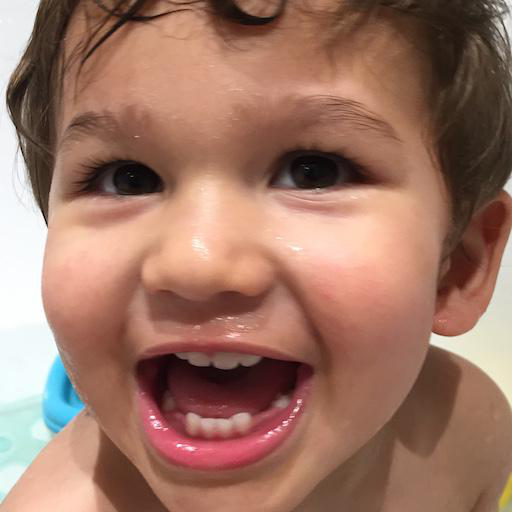

In [215]:
height=512
width=512

content_image_path = 'hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

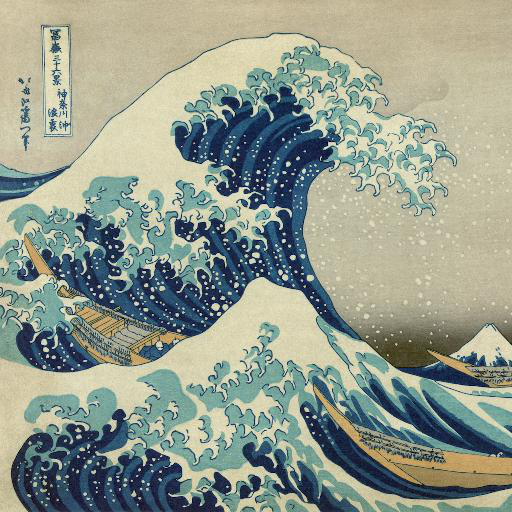

In [216]:
style_image_path = 'wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

# Step 2 Reshape data

In [217]:
content_array = np.asarray(content_image, dtype='float32')
style_array   = np.asarray(style_image, dtype='float32')
print(content_array.shape)
print(style_array.shape)

(512, 512, 3)
(512, 512, 3)


In [218]:
content_array = np.expand_dims(content_array, axis=0)
style_array   = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]/255.

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]/255.

In [0]:
combination_img = tf.Variable(content_array, dtype='float32', name='combination_image')

# Step 3 Build Model

In [0]:
content_img = tf.placeholder(dtype='float32', shape=[1,width,height,3], name='content_image')
style_img =   tf.placeholder(dtype='float32', shape=[1,width,height,3], name='style_image')

# x = (np.random.uniform(0, 255, (1, height, width, 3)) - 128.)/255.
# combination_img = tf.Variable(x, dtype='float32', name='combination_image')

In [0]:
input_tensor = tf.concat([content_img, style_img, combination_img], axis=0, name='input_tensor')

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
model.trainable=False

In [224]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_11/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_11/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_11/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_11/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_11/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_11/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_11/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_11/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_11/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_11/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_11/Relu:0' shape=(3,

In [0]:
content_weight   = tf.constant(0.025, name='content_weight')
style_weight     = tf.constant(5., name='style_weight')
variation_weight = tf.constant(1., name='variation_weight')

In [0]:
def content_loss(content_f, combination_f):
  diff = tf.subtract(combination_f, content_f)
  content_ls = tf.reduce_mean(tf.square(diff))
  return content_ls

# content_layer = 'block2_conv2'
# layer_features = layers[content_layer]
# content_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]

# total_loss = tf.multiply(content_weight, content_loss(content_features, combination_features))

In [0]:
def gram_matrix(feature_map):
  (l,w,f)=feature_map.shape
  feature_3d=tf.transpose(feature_map)
  feature_3d=tf.reshape(feature_3d,[f,l*w])
  gram = tf.matmul(feature_3d,tf.transpose(feature_3d))
  return gram

In [0]:
def style_loss(style_f, combination_f):
  style_gram = gram_matrix(style_f)
  combination_gram  = gram_matrix(combination_f)
  diff = tf.subtract(style_gram, combination_gram)
  (l,w,f) = style_f.shape
  style_ls = tf.div(tf.linalg.trace(tf.matmul(tf.transpose(diff),diff)), 
                    tf.multiply(tf.pow(tf.to_float(w),2), tf.pow(tf.to_float(l),2)))
  return style_ls


# style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
# for layer_name in style_layers:
#   layer_features = layers[layer_name]
#   style_features = layer_features[1, :, :, :]
#   combination_features  = layer_features[2, :, :, :]
#   total_loss = tf.add(total_loss, tf.multiply(style_weight, style_loss(style_features, combination_features)))

In [0]:
def variation_loss(x):
    a = tf.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = tf.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    variation_ls = tf.reduce_mean(tf.pow(a + b, 1.25))
    return variation_ls

# total_loss = total_loss + variation_weight * variation_loss(combination_img)

In [0]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(total_loss)

# init_op = tf.global_variables_initializer()

# with tf.Session() as sess:
#   sess.run(init_op)
  
#   # gradients
#   gr = tf.gradients(total_loss, combination_img)
#   print sess.run(gr, feed_dict={content_img: content_array, style_img:style_array})
  
#   # content
#   content_layer = 'block2_conv2'
#   layer_features = layers[content_layer]
#   content_features = layer_features[0, :, :, :]
# #   print sess.run(content_features, feed_dict={content_img: content_array, style_img:style_array})
#   combination_features = layer_features[2, :, :, :]
# #   print sess.run(combination_features, feed_dict={content_img: content_array, style_img:style_array})
#   diff = tf.subtract(combination_features, content_features)
#   content_ls = tf.reduce_mean(tf.square(diff))
#   print 'content loss: ', sess.run(content_ls, feed_dict={content_img: content_array, style_img:style_array})
  
#   # style
#   style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
#   for layer_name in style_layers:
#     print layer_name
#     layer_features = layers[layer_name]
#     style_features = layer_features[1, :, :, :]
#     combination_features  = layer_features[2, :, :, :]
#     style_gram        = gram_matrix(style_features)
#     combination_gram  = gram_matrix(combination_features)
#     diff = tf.subtract(style_gram, combination_gram)
#     (l,w,f) = style_features.shape
#     style_ls = tf.div(tf.linalg.trace(tf.matmul(tf.transpose(diff),diff)), tf.pow(tf.to_float(2*w*l),2))
#     print 'style loss: ', sess.run(style_ls, feed_dict={content_img: content_array, style_img:style_array})
    
#   # variation
#   a = tf.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#   b = tf.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#   variation_ls = tf.reduce_mean(tf.pow(a + b, 1.25))
#   print sess.run(variation_ls, feed_dict={content_img: content_array, style_img:style_array})
  
#   for i in range(10):
#     start_time = time.time()    
#     sess.run()
#     _, t_ls, y, g= sess.run([optimizer, total_loss, combination_img, gr], feed_dict={content_img: content_array, style_img:style_array})
#     print "total_ls:", t_ls
#     end_time = time.time()
#     print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
#   y = y.reshape((height, width, 3))
#   y = y[:, :, ::-1]
#   y[:, :, 0] += 103.939
#   y[:, :, 1] += 116.779
#   y[:, :, 2] += 123.68
#   y = np.clip(y, 0, 255).astype('uint8')
#   plt.imshow(y, interpolation='nearest')
#   plt.show()

In [0]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=20).minimize(total_loss)

# init_op = tf.global_variables_initializer()

# with tf.Session() as sess:
#   sess.run(init_op)
#   for i in range(100):
#     start_time = time.time()    
#     _, t_ls, y= sess.run([optimizer, total_loss, combination_img], 
#                          feed_dict={content_img: content_array, style_img:style_array})
#     print "total_loss:", t_ls
#     end_time = time.time()
#     print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
#     y = y.reshape((height, width, 3))
#     y = y[:, :, ::-1]*255.
#     y[:, :, 0] += 103.939
#     y[:, :, 1] += 116.779
#     y[:, :, 2] += 123.68
#     y = np.clip(y, 0, 255).astype('uint8')
#     plt.imshow(y, interpolation='nearest')
#     plt.show()

total_loss: 0.0038576091
Iteration 1 completed in 43s


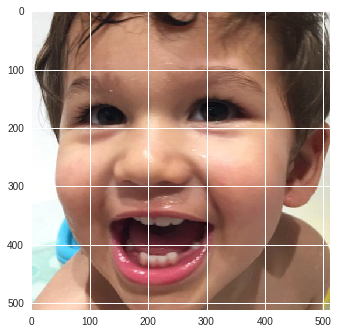

total_loss: 0.002886869
Iteration 2 completed in 63s


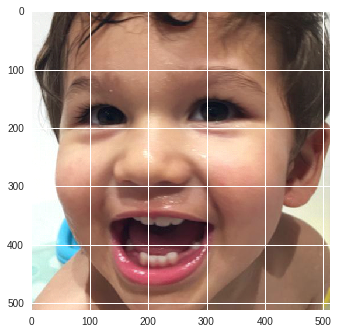

total_loss: 0.0023546417
Iteration 3 completed in 63s


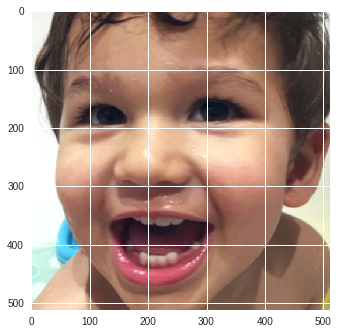

total_loss: 0.0019960639
Iteration 4 completed in 62s


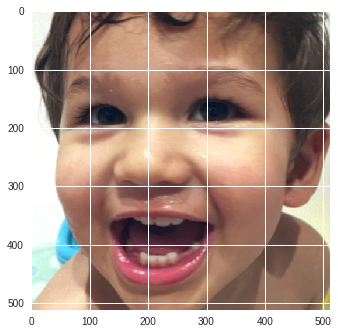

total_loss: 0.0017361512
Iteration 5 completed in 63s


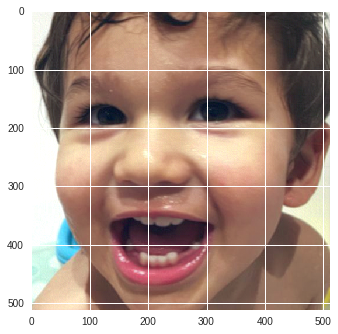

total_loss: 0.0015395391
Iteration 6 completed in 63s


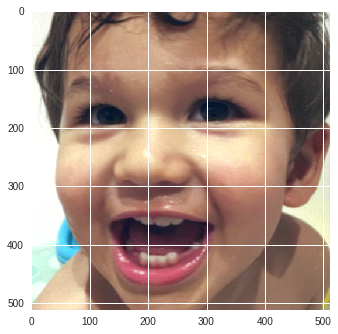

total_loss: 0.0013862363
Iteration 7 completed in 31s


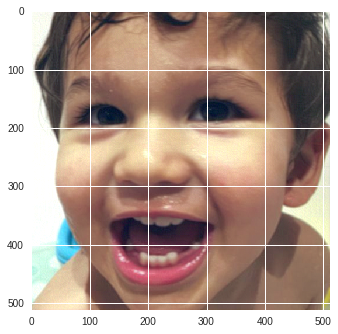

total_loss: 0.0012642462
Iteration 8 completed in 30s


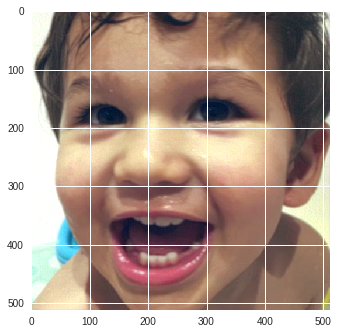

total_loss: 0.0011656637
Iteration 9 completed in 31s


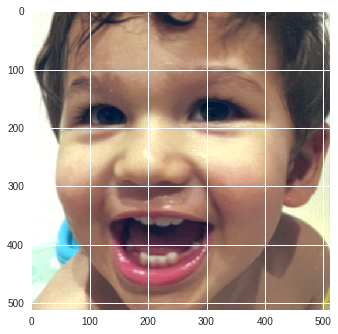

total_loss: 0.0010848457
Iteration 10 completed in 31s


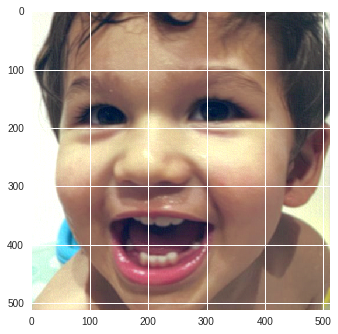

total_loss: 0.0010176431
Iteration 11 completed in 31s


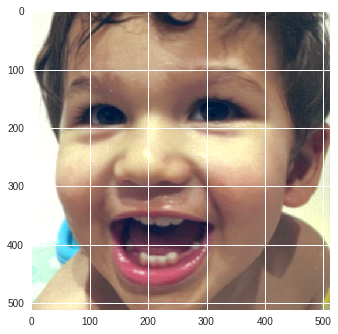

total_loss: 0.000961055
Iteration 12 completed in 31s


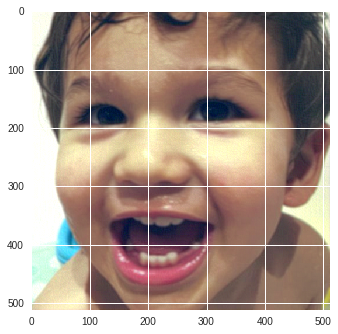

total_loss: 0.0009128641
Iteration 13 completed in 31s


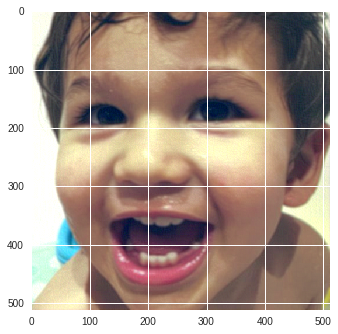

total_loss: 0.0008713959
Iteration 14 completed in 31s


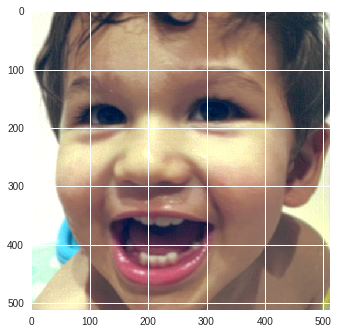

total_loss: 0.00083542475
Iteration 15 completed in 31s


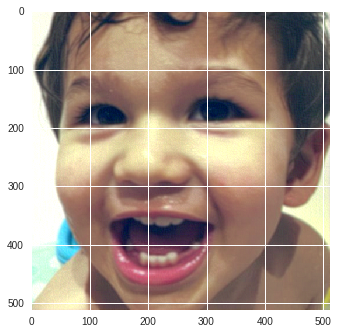

total_loss: 0.0008040109
Iteration 16 completed in 31s


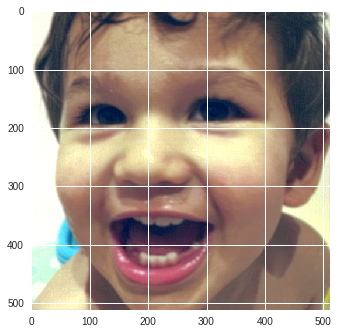

total_loss: 0.00077638496
Iteration 17 completed in 32s


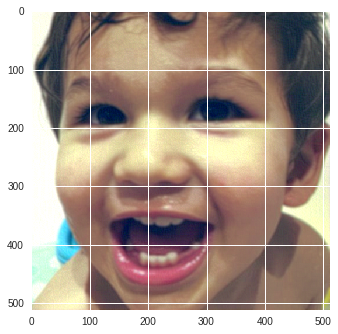

total_loss: 0.0007519616
Iteration 18 completed in 31s


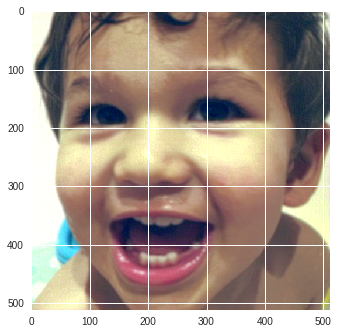

total_loss: 0.00073024584
Iteration 19 completed in 31s


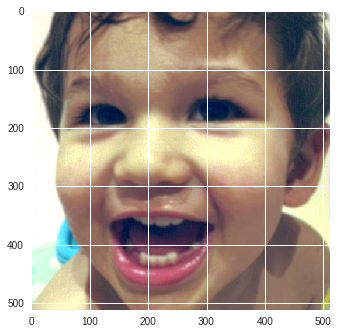

In [0]:
init_op = tf.global_variables_initializer()

# combination_img = tf.Variable(style_array, dtype='float32', name='combination_image')
    
content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
total_loss = tf.multiply(content_weight, content_loss(content_features, combination_features))

style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for layer_name in style_layers:
  layer_features = layers[layer_name]
  style_features = layer_features[1, :, :, :]
  combination_features  = layer_features[2, :, :, :]
  total_loss = tf.add(total_loss, tf.multiply(style_weight, style_loss(style_features, combination_features)))

total_loss = total_loss + variation_weight * variation_loss(combination_img)

grads = tf.gradients(ys=total_loss, xs=combination_img)
learning_rate = 1e5
new_combination_img = combination_img.assign(combination_img - tf.multiply(grads[0],learning_rate))
# print sess.run(new_combination_img, feed_dict={content_img: content_array, style_img:style_array})

with tf.Session() as sess:
  
  sess.run(init_op)

  for i in range(100):
    start_time = time.time()   
    
    y, t_ls= sess.run([new_combination_img, total_loss], 
                         feed_dict={content_img: content_array, style_img:style_array})
    print "total_loss:", t_ls
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
    y = y.reshape((height, width, 3))
    y = y[:, :, ::-1]*255.
    y[:, :, 0] += 103.939
    y[:, :, 1] += 116.779
    y[:, :, 2] += 123.68
    y = np.clip(y, 0, 255).astype('uint8')
    plt.imshow(y, interpolation='nearest')
    plt.show()

In [0]:
combination_img.shape